# Prepare belowground biomass data (Huang)

In [1]:
# Libraries
import os, time, shutil, rioxarray
import numpy as np
import xarray as xr
from scipy import ndimage
import matplotlib.pyplot as plt

from dask.distributed import Lock

In [2]:
# Directories
dir_data =  '../data/'
dir01 = '../paper_deficit/output/01_prep/'

---

In [3]:
# Libraries
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask

# Initialize dask
cluster = SLURMCluster(
    queue='compute',                      # SLURM queue to use
    cores=24,                             # Number of CPU cores per job
    memory='256 GB',                      # Memory per job
    account='bm0891',                     # Account allocation
    interface="ib0",                      # Network interface for communication
    walltime='00:30:00',                  # Maximum runtime per job
    local_directory='../dask/',           # Directory for local storage
    job_extra_directives=[                # Additional SLURM directives for logging
        '-o ../dask/LOG_worker_%j.o',     # Output log
        '-e ../dask/LOG_worker_%j.e'      # Error log
    ]
)

# Scale dask cluster
cluster.scale(jobs=2)

# Configurate dashboard url
dask.config.config.get('distributed').get('dashboard').update(
    {'link': '{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'}
)

# Create client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /user/b381155/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/b381155/levante-spawner-preset//proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.128.5.68:39911,Workers: 0
Dashboard: /user/b381155/levante-spawner-preset//proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# Function to trim memory of workers
def trim_memory() -> int:
    import ctypes
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

In [5]:
def prep_huang():

    """Prepare Huang data for regridding"""
    
    def load_data(file): 
    
        # Get data
        ds = xr.open_dataset(
            os.path.join(dir_data, f"huang2021/data_code_to_submit/", file),
            chunks=dict(lat=10000, lon=10000), lock=False)
    
        # Rename lat and lon
        ds = ds.rename(dict(LAT='lat', LON='lon'))
        # Reindex lat
        ds = ds.reindex(lat=ds.lat[::-1])    
        
        return ds
    
    def export_tif(da, file):
        # Export as geotif
        da.rio.to_raster(os.path.join(dir01, file), 
                         tiled=True,
                         lock=Lock("rio"))
    
    # AGB
    ds_agb = load_data('pergridarea_agb.nc')
    da_agb = ds_agb['ASHOOT'].rename('huang_agb')
    export_tif(da_agb, 'huang_agb.tif')
    
    # BGB
    ds_bgb = load_data('pergridarea_bgb.nc')
    da_bgb = ds_bgb['AROOT'].rename('huang_bgb')
    export_tif(da_bgb, 'huang_bgb.tif')
    
    # BGB uncertainty
    ds_bgbunc = load_data('err_bgb_15_99_ncomm_revise.nc')
    da_bgbunc = ds_bgbunc['ROOT_ERR'].rename('huang_bgbunc')
    export_tif(da_bgbunc, 'huang_bgbunc.tif')
    
    # BGB/ABG ratio
    da_bgbagbratio = (da_bgb / da_agb).rename('huang_bgbagbratio')
    export_tif(da_bgbagbratio, 'huang_bgbagbratio.tif')


%time prep_huang()

CPU times: user 1.7 s, sys: 5.97 s, total: 7.67 s
Wall time: 2min 1s


In [6]:
cluster.close()

---

In [8]:
# Import regridding function
from regrid_high_res_v1_01 import regrid_high_res, prep_tif

In [9]:
def regrid_da(f_source, dir_target, dir_source, dir_out, 
              size_tiles, fill_value=None, olap=1):  
    """Regrid large xarray dataarrays.

    Args:
        f_source (str): The filename (without extension) of the source .tif file to be regridded.
        dir_target (str): Directory containing target grid .tif file.
        dir_source (str): Directory containing the the source  .tif file.
        dir_out (str): Directory to store the output and intermediate files.
        size_tiles (int): Size of the regridding tiles in degrees.
        fill_value (float, optional): Fill value to use in the regridding process. Defaults to None.
        olap (int, optional): Overlap size in degrees for regridding tiles. Defaults to 1.
        
    Returns:
        xarray.Dataset: The combined dataset after regridding.
    """
    # Prepare the target and source data arrays from TIFF files
    da_target = prep_tif(dir_target + 'target_grid.tif', 'target_grid')
    da_source = prep_tif(dir_source + f_source + '.tif', f_source)
    # Regridd source array to target grid
    regrid_high_res(da_target, da_source, dir_out,
                    account='bm0891', partition='shared',
                    size_tiles=size_tiles, olap=olap, fill_value = fill_value,
                    type_export='zarr', del_interm=False)

In [10]:
# regridding
for i in ['huang_agb', 'huang_bgb', 'huang_bgbunc', 'huang_bgbagbratio']:
    %time regrid_da(i, dir01, dir01, dir01, 20, np.nan, 0.2)
# takes about 4min for one file

CPU times: user 9.34 s, sys: 16.9 s, total: 26.3 s
Wall time: 4min 44s
CPU times: user 9.56 s, sys: 16.5 s, total: 26.1 s
Wall time: 4min 56s
CPU times: user 9.13 s, sys: 15.1 s, total: 24.3 s
Wall time: 4min 57s
CPU times: user 7.99 s, sys: 16.3 s, total: 24.3 s
Wall time: 4min 30s


---

### Fill nans

In [11]:
def fill_nans(var, dir_out):
    """
    Fills NaN values in the specified variable's dataset using the nearest valid 
    data, applies a land mask, and exports the result to a new Zarr dataset.

    Args:
        var (str): Name of the variable to process (e.g., 'temperature', 'precipitation').
        dir_out (str): Directory where prepared data is stored and the filled dataset will be exported.

    Returns:
        None
    """

    def fill_nans_array(data, invalid):
        """
        Replace invalid (NaN) data cells by the value of the nearest valid data 
        cell.
        """
        ind = ndimage.distance_transform_edt(invalid,
                                             return_distances=False,
                                             return_indices=True)
        return data[tuple(ind)]

    # Paths for input and output
    land_mask_path = os.path.join(dir_out, 'ds_prep_copernicus_land_mask.zarr')
    var_data_path = os.path.join(dir_out, f'ds_regridded_{var}.zarr')
    output_path = os.path.join(dir_out, f'ds_prep_{var}.zarr')

    # Read land mask data
    da_land = xr.open_zarr(land_mask_path) \
                .chunk(dict(lat=5000, lon=5000)) \
                .copernicus_land_mask \
                .compute()

    # Read variable data
    da_var = xr.open_zarr(var_data_path)['regridded_' + var]

    # Fill nan using function fill_nans_array
    # If there are no NaNs, skip filling process
    if not da_var.isnull().any():
        da_fill = da_var.values  # No filling required
    else:
        da_fill = fill_nans_array(da_var.values, da_var.isnull().values)

    # Create a new Dataset with filled data
    ds_filled = xr.Dataset(dict(lat = da_var.lat, lon=da_var.lon))
    ds_filled[var] = (('lat', 'lon'), da_fill)

    # Apply land mask to the filled data
    ds_filled = ds_filled.where(da_land)

    # Export the filled dataset to Zarr format
    ds_filled.chunk(dict(lat=5000, lon=5000)) \
             .to_zarr(output_path, mode='w')

In [12]:
%%time
for i in ['huang_agb', 'huang_bgb', 'huang_bgbunc', 'huang_bgbagbratio']:
    %time fill_nans(i, dir01)

CPU times: user 1min 11s, sys: 37.8 s, total: 1min 49s
Wall time: 1min 14s
CPU times: user 1min 12s, sys: 37.4 s, total: 1min 49s
Wall time: 1min 15s
CPU times: user 1min 10s, sys: 38.2 s, total: 1min 48s
Wall time: 1min 13s
CPU times: user 1min 11s, sys: 41 s, total: 1min 52s
Wall time: 1min 14s
CPU times: user 4min 45s, sys: 2min 34s, total: 7min 20s
Wall time: 4min 57s


---

### Check

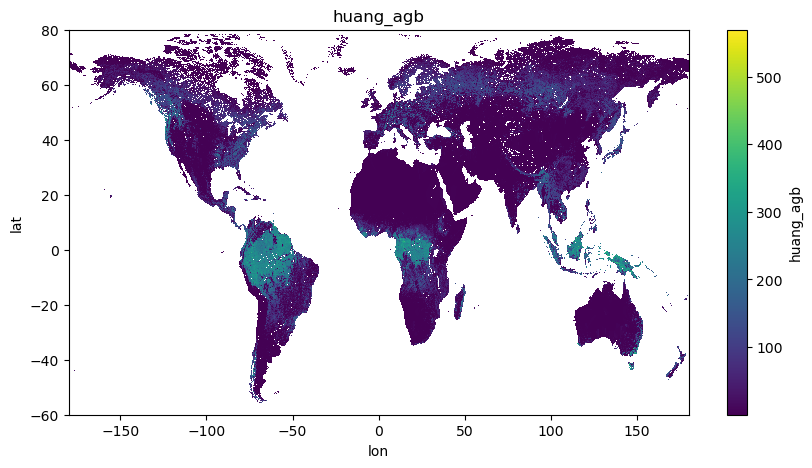

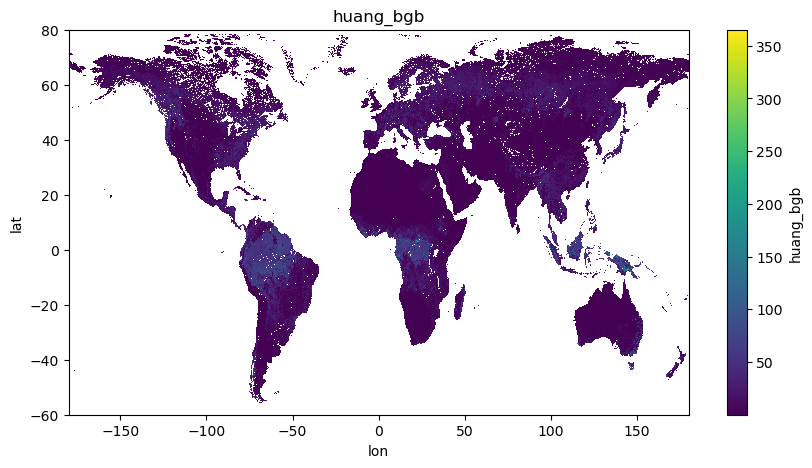

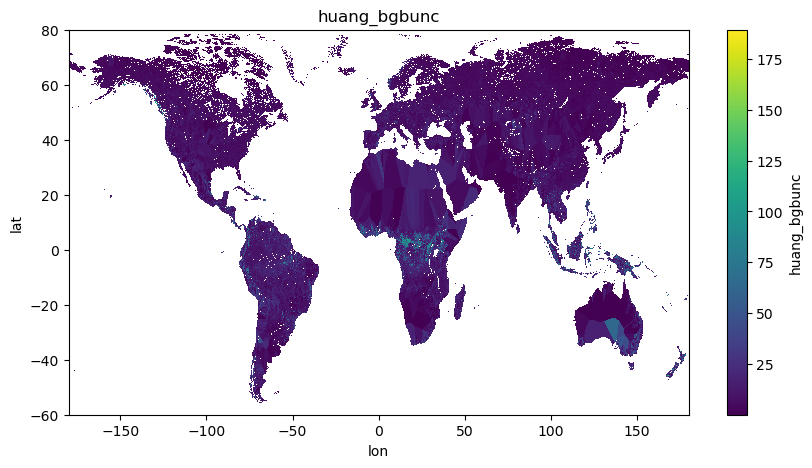

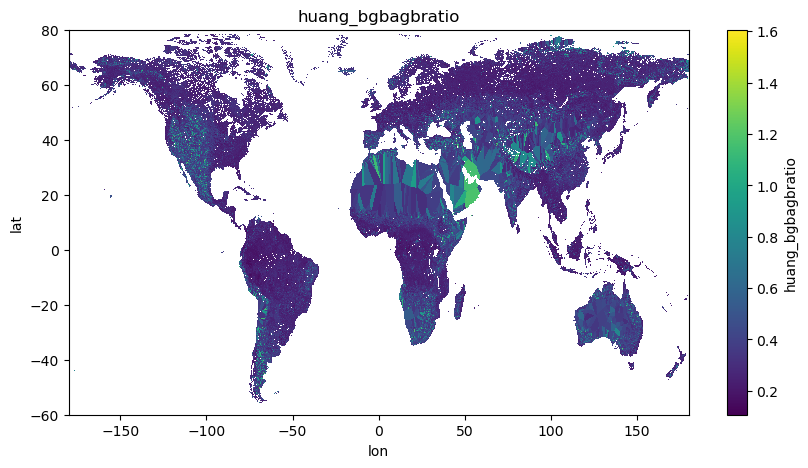

In [13]:
# Plot to check
for i in ['huang_agb', 'huang_bgb', 'huang_bgbunc', 'huang_bgbagbratio']:
    fig, ax = plt.subplots(figsize=(10, 5), ncols=1, nrows=1)
    xr.open_zarr(dir01 + 'ds_prep_' + i + '.zarr')[i] \
        .plot.imshow(ax=ax)
    ax.set_title(i)